In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from helper_funcs import *
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor


In [ ]:
## Clustering Zip Codes -------------------------------------

In [33]:
zip_data = pd.read_csv('https://nycdsacapstone2021.blob.core.windows.net/additionaldata/final_zip_data.csv', index_col=0)

In [35]:
### Cluster zip codes to feed into redfin data
## For now, keeping numerical columns that have no null values 

cols_to_cluster = [ 'Population', 'HouseholdsPerZipCode',
       'WhitePopulation', 'BlackPopulation', 'HispanicPopulation',
       'AsianPopulation', 'IndianPopulation', 'OtherPopulation',
       'MalePopulation', 'FemalePopulation', 'AverageHouseValue']
zip_cluster = zip_data[cols_to_cluster]

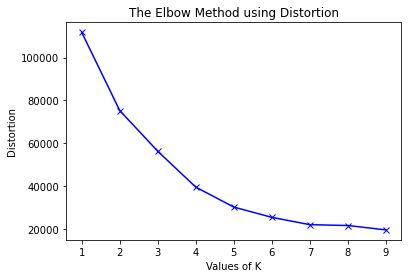

In [36]:
### Use elbow method to determine number of clusters
X = zip_cluster
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [37]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(zip_cluster)
zip_data['cluster'] = kmeans.labels_

In [47]:
zip_data.groupby('cluster')['Population','AverageHouseValue'].mean()

<ipython-input-47-e7015c8296f9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  zip_data.groupby('cluster')['Population','AverageHouseValue'].mean()


,Population,AverageHouseValue
cluster,,
0,16886.140479,191525.565912
1,182.160628,1497.624799
2,16704.774590,538286.475410
3,18176.990291,327611.511789
4,12405.038462,948623.076923
5,7678.594758,100656.401210


In [49]:
zip_clusters = zip_data[['cluster']]
zip_clusters = zip_clusters.reset_index()

In [56]:
zip_clusters

,ZipCode,cluster
0,20001,2
1,20002,2
2,20003,4
3,20004,2
4,20005,2
...,...,...
6982,56972,1
6983,56973,1
6984,56998,1
6985,56999,1


In [59]:
### Merge zips into data

In [74]:
RF = get_all()
RF = pd.merge(RF, zip_clusters, how = 'left', left_on = 'zip', right_on = 'ZipCode')


----pulling Redfin data from Azure storage----
----Done----
----pulling schools data from Azure storage----
----Done----
----merging all data----
----Done----
Shape: (75360, 22)


In [ ]:
RF.drop(RF[RF.BEDS.isna() | RF.BATHS.isna()].index, inplace=True)
RF.loc[RF.overallRating.isna(),'overallRating'] = 5
### Split data into train test split
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
    
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
    
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

In [105]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
## Use base models

In [104]:
### Linear Regression
# lm = LinearRegression()
lm = Lasso(alpha=0.1)
lm.fit(X_train, y_train)
print(f'train R2: {lm.score(X_train, y_train)}')
print(f'train R2: {lm.score(X_test, y_test)}')

ValueError: could not convert string to float: 'Condo/Co-op'

In [99]:
## CatBoost
X_train_le = X_train.copy()
X_test_le = X_test.copy()


le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
# X_train_le.zip = le.fit_transform(X_train_le.zip)
# X_test_le.zip = le.fit_transform(X_test_le.zip)
cat = CatBoostRegressor(verbose=False)
cat.get_params()
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8521649206421711
Test R2: 0.8229954428885575
